In [1]:
import operator
from collections import Counter
from scipy.stats import iqr
import sys
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import math
import random
import tensorflow as tf
import scipy
import copy

%matplotlib inline

# Graphics modules
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.path as path
import matplotlib.animation as animation

In [2]:
gas_data = pd.read_csv('example_gas_data')
gas_data.head()

,depth,Data_1,Data_2
0,1000,1.8943,NaN
1,1001,2.0972,NaN
2,1002,1.9410,NaN
3,1003,1.9492,NaN
4,1004,1.9583,NaN


#### Outlier detector. 

In [3]:
np.seterr(all = 'raise') # For debugging. 

# Expects depth column key and measurement column key. 
# Null values NaN.

### Utility functions ###

# In: Column data (NumPy array).
# Out: Arrays of means, standard deviations, minima, IQR in window. 
def get_local_stats(data, window_size, remove_n = None):
    # Data padded with null values for computation near ends. 
    half_window = window_size // 2
    padding = np.empty((half_window))
    padding[:] = np.nan
    padded_data = np.concatenate((padding, data, padding), axis = 0)
    # Output arrays. 
    means_array = np.empty([len(data)])
    means_array[:] = np.nan
    devs_array = np.empty([len(data)])
    devs_array[:] = np.nan
    mins_array = np.empty([len(data)])
    mins_array[:] = np.nan
    median_array = np.empty([len(data)])
    median_array[:] = np.nan
    IQR_array = np.empty([len(data)])
    IQR_array[:] = np.nan
    # Start index and default minimum gate. 
    index = half_window
    if not remove_n:
        remove_n = window_size // 10
    # Iterate.
    for i in range(len(data)):
        local_data = np.concatenate((padded_data[index-half_window : index], padded_data[index + 1 : index + half_window + 1]))
        local_data = local_data[~np.isnan(local_data)]
        if len(local_data) < half_window:
            index += 1
            continue
        local_data = np.sort(local_data)
        mins_array[i] = local_data[remove_n]
        means_array[i] = local_data.mean()
        devs_array[i] = local_data.std()
        median_array[i] = np.median(local_data)
        IQR_array[i] = scipy.stats.iqr(local_data)
        index += 1
    return means_array, devs_array, mins_array, median_array, IQR_array

# In: Column data (NumPy array).
# Out: Data scaled by first_local_mean/mean and translated to a zero minimum, array of scale factors.
def scale_and_locate(data, window_size):
    means, _, mins, _, _ = get_local_stats(data, window_size)
    smooth_mins, _, _, _, _ = get_local_stats(mins, window_size = 5)
    transformed_data = np.empty((len(data)))
    transformed_data[:] = np.nan
    inverse_scale_factors = np.empty((len(data)))
    inverse_scale_factors[:] = np.nan
    start_mean = means[~np.isnan(means)][0]
    for i in range(len(data)):
        if (not np.isnan(mins[i])) and not (np.isnan(means[i])):
            adjustment = mins[i]
            scale_factor = start_mean/means[i]
            inverse_scale_factors[i] = 1/scale_factor
            transformed_data[i] = max(scale_factor*(data[i] - adjustment), 0)
    return transformed_data, inverse_scale_factors, smooth_mins

# In: Data array.
# Out: Parameters for gamma distribution of given data.
def fit_gamma_closed_estimator(data, gamma_mode = "unbiased"):
    data = data + 1e-16 # Nudge to avoid log(0).
    N = len(data)
    data_sum = np.sum(data)
    data_log_sum = np.sum(np.log(data))
    data_log_dot = np.dot(data, np.log(data))
    k_hat = N * data_sum/(N * data_log_dot - data_log_sum * data_sum)
    theta_hat = (N * data_log_dot - data_log_sum * data_sum) / (N**2)
    if gamma_mode == 'biased':
        return k_hat, theta_hat
    else:
        k_tilde = k_hat - (3 * k_hat - (2 / 3) * (k_hat / (1 + k_hat)) - (4 / 5) * (1 / ((1 + k_hat)**2))) / N
        theta_tilde = theta_hat * N/(N - 1)
        return k_tilde, theta_tilde

# In: Gamma parameters and value.
# Out: CDF evaluated at value. 
def gamma_cdf(k, theta, x):
    return scipy.special.gammainc(k, x/theta)

# In: Column data (NumPy array).
# Out: Array giving local gamma parameters and outlier threshold. 
# Note: Threshold is .95 to declare the 5% right tail as outliers. 
def fit_gamma_along_curve(data, window_size, threshold, bisection_stop):
    half_window = window_size // 2
    padding = np.empty((half_window))
    padding[:] = np.nan
    padded_data = np.concatenate((padding, data, padding), axis = 0)
    parameter_array = np.empty([len(data), 3])
    parameter_array[:] = np.nan
    index = half_window
    b = 2
    warning = 0
    for i in range(len(data)):
        local_data = np.concatenate((padded_data[index-half_window : index], padded_data[index + 1 : index + half_window + 1]))
        local_data = local_data[~np.isnan(local_data)] ### Here's your problem.
        if len(local_data) < half_window:
            index += 1
            continue
        local_k, local_theta = fit_gamma_closed_estimator(local_data)
        ### Bisection search for critical value ###
        a = 0
        error = bisection_stop * 2
        while gamma_cdf(local_k, local_theta, b) < threshold:
            b = 2 * b
        while error > bisection_stop:
            local_critical = (a+b)/2
            cdf_value = gamma_cdf(local_k, local_theta, local_critical)
            if cdf_value > threshold:
                b = local_critical
            else:
                a = local_critical
            error = abs(cdf_value - threshold)
        ### ----------------------------------- ###
        parameter_array[i,0] = local_k
        parameter_array[i,1] = local_theta
        parameter_array[i,2] = local_critical
        index += 1
    return parameter_array

### Outlier Detector ###

class GammaOutlierDetector:
    
    def __init__(self, 
                 data, 
                 target_key, 
                 depth_key,
                 detector_mode = "continuous",
                 gamma_mode = "unbiased", 
                 window_size = 100, 
                 threshold = .95, 
                 bisection_stop = 1e-10, 
                 transform = True, 
                 supress_lower = True):
    
        self.data = copy.deepcopy(data)
        self.target_key = target_key
        self.depth_key = depth_key
        self.column = self.data[self.target_key]
        self.detector_mode = detector_mode
        self.gamma_mode = gamma_mode
        self.window_size = window_size
        self.threshold = threshold
        self.bisection_stop = bisection_stop
        self.transform = transform
        self.supress_lower = supress_lower
    
    def detect_continuous(self):
        outlier_array = np.zeros(len(self.data))
        if self.transform:
            fit_target, inverse_scale_factors, mins = scale_and_locate(self.column, window_size = self.window_size)
            parameter_array = fit_gamma_along_curve(fit_target, 
                                                    window_size = self.window_size, 
                                                    threshold = self.threshold, 
                                                    bisection_stop = self.bisection_stop)
        else:
            parameter_array = fit_gamma_along_curve(self.column, 
                                                    window_size = self.window_size, 
                                                    threshold = self.threshold, 
                                                    bisection_stop = self.bisection_stop)
        self.data[self.target_key + ' local k'] = parameter_array[:, 0]
        self.data[self.target_key + ' local theta'] = parameter_array[:, 1]
        self.data[self.target_key + ' local critical'] = parameter_array[:, 2]
        if self.transform:
            for i in range(len(inverse_scale_factors)):
                self.data[self.target_key + ' local critical'][i] = self.data[self.target_key + ' local critical'][i] * inverse_scale_factors[i] + mins[i]
        for i in range(len(self.column)):
            if ~np.isnan(self.column[i]) and self.column[i] > self.data[self.target_key + ' local critical'][i]:
                outlier_array[i] = 1
        self.data[self.target_key + ' outlier'] = outlier_array
    
    def detect_discrete(self):
        minor_outlier_array = np.zeros(len(self.data))
        major_outlier_array = np.zeros(len(self.data))
        outlier_array = np.zeros(len(self.data))
        _, _, _, median, IQR = get_local_stats(self.column, window_size = self.window_size)
        self.data[self.target_key + ' ILF'] = median - 1.5 * IQR
        self.data[self.target_key + ' IUF'] = median + 1.5 * IQR
        self.data[self.target_key + ' OLF'] = median - 3 * IQR
        self.data[self.target_key + ' OUF'] = median + 3 * IQR
        for i in range(len(self.column)):
            if np.isnan(self.column[i]):
                continue
            if self.column[i] < self.data[self.target_key + ' ILF'][i] or self.column[i] > self.data[self.target_key + ' IUF'][i]:
                minor_outlier_array[i] = 1
            if self.column[i] < self.data[self.target_key + ' OLF'][i] or self.column[i] > self.data[self.target_key + ' OUF'][i]:
                major_outlier_array[i] = 1
        for i in range(len(self.column)):
            if major_outlier_array[i] == 1:
                minor_outlier_array[i] = 0
        outlier_array = minor_outlier_array + major_outlier_array
        self.data[self.target_key + ' minor outlier'] = minor_outlier_array
        self.data[self.target_key + ' major outlier'] = major_outlier_array
        self.data[self.target_key + ' outlier'] = outlier_array
            
        
    def detect(self):
        if self.detector_mode == "discrete":
            self.detect_discrete()
        else:
            self.detect_continuous()
            
    def display(self):
        if self.detector_mode == "discrete":
            X = self.data[self.depth_key]
            minor_outliers_X = self.data[self.depth_key].loc[self.data[self.target_key + ' minor outlier'] == 1]
            minor_outliers = self.data[self.target_key].loc[self.data[self.target_key + ' minor outlier'] == 1]
            major_outliers_X = self.data[self.depth_key].loc[self.data[self.target_key + ' major outlier'] == 1]
            major_outliers = self.data[self.target_key].loc[self.data[self.target_key + ' major outlier'] == 1]
            nonoutliers_X = self.data[self.depth_key].loc[self.data[self.target_key + ' outlier'] == 0]
            nonoutliers = self.data[self.target_key].loc[self.data[self.target_key + ' outlier'] == 0]
            if not self.supress_lower:
                ILF = self.data[self.target_key + ' ILF']
                OLF = self.data[self.target_key + ' OLF']
            IUF = self.data[self.target_key + ' IUF']
            OUF = self.data[self.target_key + ' OUF']
            plt.figure(figsize=(20,10))
            plt.plot(nonoutliers_X, nonoutliers, '.', color = 'b', label = 'non-outliers')
            plt.plot(minor_outliers_X, minor_outliers, '.', color = 'y', label = 'minor outliers')
            plt.plot(major_outliers_X, major_outliers, '.', color = 'r', label = 'major outliers')
            if not self.supress_lower:
                plt.plot(X, ILF, color = 'm', label = 'inner lower fence')
                plt.plot(X, OLF, color = 'g', label = 'outer lower fence')
            plt.plot(X, IUF, color = 'm', label = 'inner upper fence')
            plt.plot(X, OUF, color = 'g', label = 'outer upper fence')
            plt.legend()
            plt.show()
        else:
            X = self.data[self.depth_key]
            outlier_X = self.data[self.depth_key].loc[self.data[self.target_key + ' outlier'] == 1]
            nonoutlier_X = self.data[self.depth_key].loc[self.data[self.target_key + ' outlier'] == 0]
            outliers = self.column.loc[self.data[self.target_key + ' outlier'] == 1]
            non_outliers = self.column.loc[self.data[self.target_key + ' outlier'] == 0]
            local_critical = self.data[self.target_key + ' local critical']
            plt.figure(figsize=(20,10))
            plt.plot(nonoutlier_X, non_outliers, '.', color = 'b', label = 'non-outliers')
            plt.plot(outlier_X, outliers, '.', color = 'r', label = 'outliers')
            plt.plot(X, local_critical, '-', color = 'g', label = 'threshold')
            plt.legend()
            plt.show()
            
    def detect_and_display(self):
        self.detect()
        self.display()
    
    def get_outlier_depths(self):
        return np.sort(self.data.loc[self.data[self.target_key + ' outlier'] == 1][self.depth_key].values)
    
    def get_minor_outlier_depths(self):
        assert self.detector_mode == 'discrete', 'Minor outlier detection only defined in discrete mode.'
        return np.sort(self.data.loc[self.data[self.target_key + ' minor outlier'] == 1][self.depth_key].values)
    
    def get_major_outlier_depths(self):
        assert self.detector_mode == 'discrete', 'Minor outlier detection only defined in discrete mode.'
        return np.sort(self.data.loc[self.data[self.target_key + ' major outlier'] == 1][self.depth_key].values)
    
    def report_outlier_depths(self):
        if self.detector_mode == 'continuous':
            depths = self.get_outlier_depths()
            print("%d outliers"%len(depths), end = " ")
            if len(depths) > 0:
                print("(depths): ", end = " ")
                for i in range(len(depths) - 1):
                    print(depths[i], end = ", ")
                print(depths[-1])
        else:
            minor_depths = self.get_minor_outlier_depths()
            print("%d minor outliers"%len(minor_depths), end = "")
            if len(minor_depths) > 0:
                print(" (depths): ", end = " ")
                for i in range(len(minor_depths) - 1):
                    print(minor_depths[i], end = ", ")
                print(minor_depths[-1], end = "\n\n")
            else:
                print(".")
            major_depths = self.get_major_outlier_depths()
            print("%d major outliers"%len(major_depths), end = "")
            if len(major_depths) > 0:
                print(" (depths): ", end = " ")
                for i in range(len(major_depths) - 1):
                    print(major_depths[i], end = ", ")
                print(major_depths[-1], end = "\n\n")
            else:
                print(".")
        
    def clean(self):
        for i in range(len(self.data)):
            if self.data[self.target_key + ' outlier'][i] == 1:
                self.data[self.target_key][i] = np.nan

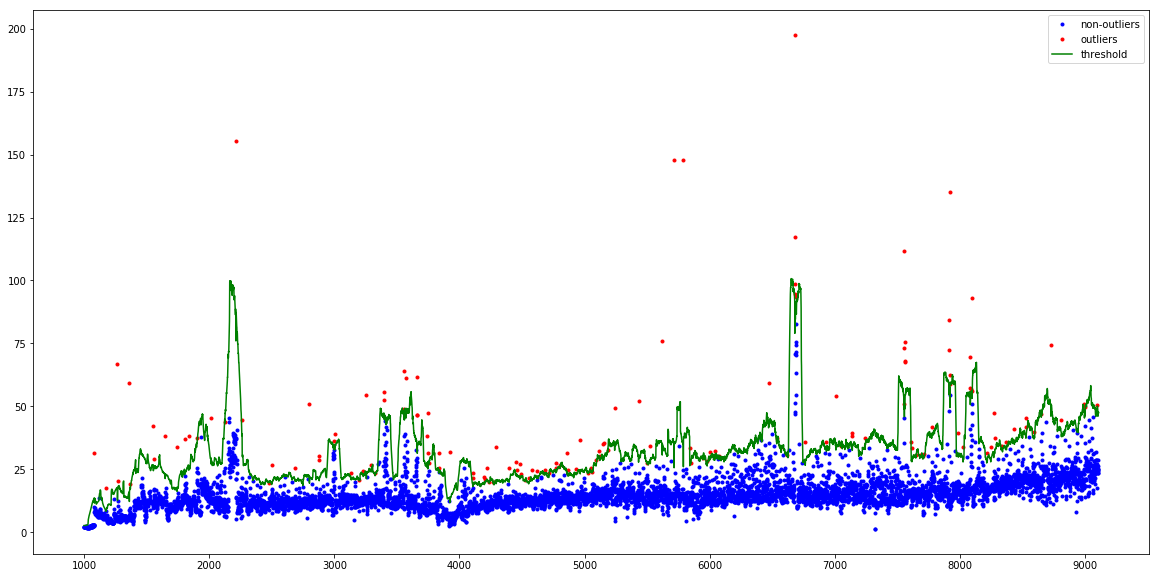

153 outliers (depths):  1083, 1178, 1267, 1268, 1362, 1370, 1554, 1557, 1648, 1743, 1804, 1837, 1899, 2016, 2125, 2213, 2261, 2475, 2499, 2687, 2801, 2878, 2879, 2995, 3003, 3135, 3199, 3231, 3256, 3294, 3325, 3399, 3400, 3556, 3560, 3572, 3659, 3660, 3663, 3742, 3746, 3747, 3754, 3835, 3837, 3924, 4106, 4108, 4199, 4206, 4221, 4237, 4269, 4294, 4397, 4455, 4458, 4482, 4490, 4522, 4553, 4578, 4618, 4681, 4713, 4769, 4775, 4802, 4861, 4868, 4932, 4965, 5028, 5053, 5060, 5091, 5118, 5120, 5145, 5152, 5184, 5240, 5431, 5496, 5525, 5620, 5715, 5789, 5840, 5848, 5943, 5979, 6000, 6039, 6071, 6470, 6540, 6572, 6615, 6680, 6681, 6683, 6684, 6692, 6763, 6932, 7008, 7047, 7136, 7139, 7242, 7551, 7555, 7556, 7557, 7558, 7559, 7608, 7615, 7646, 7678, 7703, 7710, 7773, 7912, 7914, 7916, 7917, 7919, 7986, 8024, 8082, 8083, 8084, 8093, 8097, 8213, 8245, 8269, 8276, 8339, 8364, 8422, 8434, 8526, 8528, 8591, 8649, 8726, 8810, 8994, 8999, 9094


In [4]:
continuous_detector = GammaOutlierDetector(gas_data, 'Data_1', 'depth', threshold = .95)
continuous_detector.detect_and_display()
continuous_detector.report_outlier_depths()

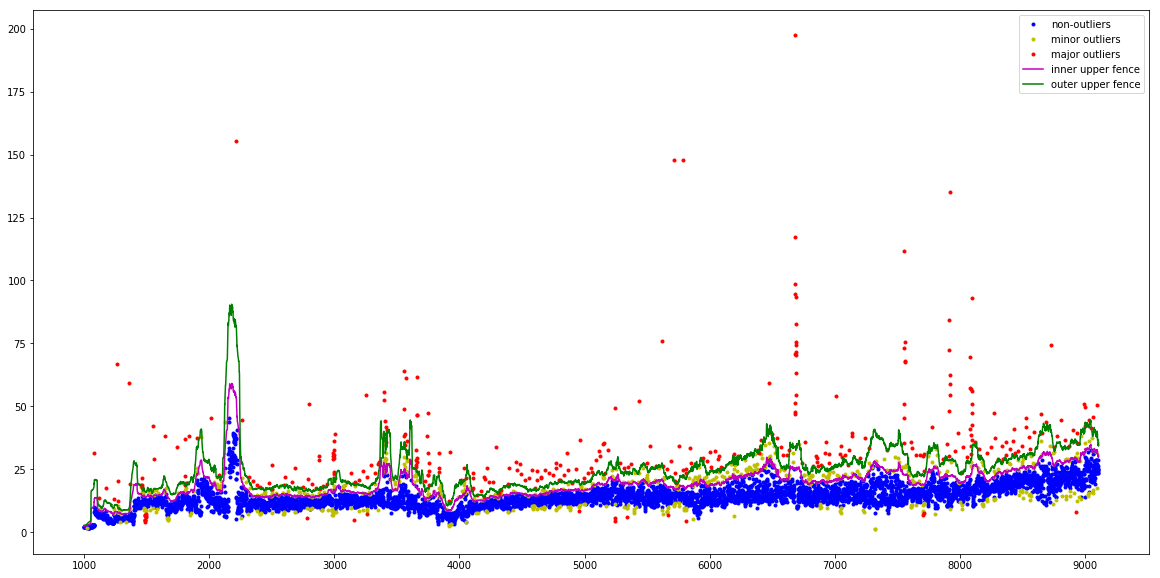

625 minor outliers (depths):  1020, 1124, 1125, 1238, 1239, 1269, 1272, 1284, 1286, 1287, 1297, 1339, 1363, 1364, 1458, 1463, 1465, 1466, 1468, 1470, 1472, 1474, 1482, 1483, 1484, 1496, 1499, 1521, 1522, 1523, 1524, 1547, 1555, 1556, 1560, 1561, 1575, 1576, 1583, 1592, 1650, 1652, 1666, 1667, 1668, 1669, 1670, 1671, 1749, 1807, 1808, 1813, 1850, 1851, 1876, 1901, 1902, 1903, 1907, 1934, 2036, 2060, 2061, 2062, 2064, 2087, 2088, 2090, 2091, 2093, 2116, 2118, 2125, 2258, 2260, 2298, 2311, 2325, 2349, 2382, 2385, 2408, 2409, 2410, 2412, 2438, 2443, 2444, 2494, 2496, 2498, 2500, 2502, 2503, 2504, 2535, 2546, 2567, 2588, 2592, 2593, 2594, 2596, 2601, 2630, 2685, 2688, 2689, 2694, 2717, 2719, 2726, 2757, 2783, 2785, 2798, 2808, 2819, 2821, 2824, 2842, 2876, 2877, 2880, 2881, 2898, 2899, 2900, 2914, 2947, 2977, 2979, 2981, 2983, 2984, 2985, 2986, 2987, 2991, 2992, 2999, 3000, 3006, 3010, 3064, 3066, 3071, 3072, 3083, 3137, 3167, 3201, 3230, 3233, 3258, 3264, 3273, 3274, 3284, 3326, 3333, 3351

In [5]:
discrete_detector = GammaOutlierDetector(gas_data, 'Data_1', 'depth', detector_mode = 'discrete')
discrete_detector.detect_and_display()
discrete_detector.report_outlier_depths()

In [6]:
discrete_detector.clean()

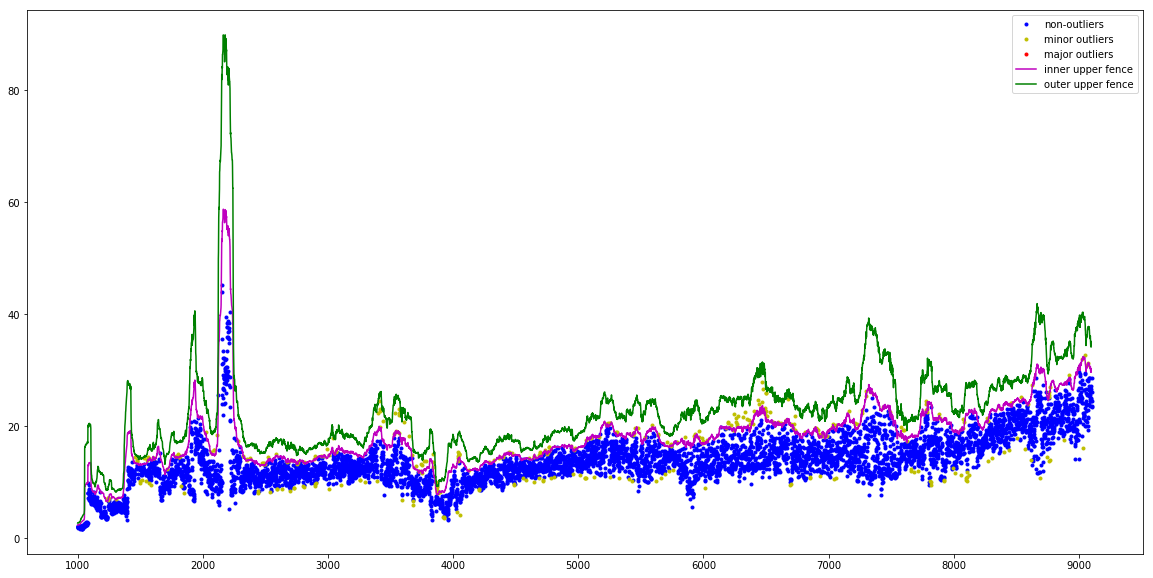

356 minor outliers (depths):  1240, 1241, 1242, 1243, 1246, 1306, 1462, 1471, 1473, 1476, 1495, 1498, 1512, 1529, 1550, 1558, 1564, 1565, 1569, 1585, 1602, 1603, 1609, 1718, 1783, 1801, 1809, 1811, 1814, 1815, 1826, 1849, 2030, 2063, 2089, 2092, 2117, 2284, 2323, 2354, 2355, 2381, 2441, 2445, 2476, 2482, 2485, 2490, 2492, 2497, 2518, 2537, 2589, 2595, 2597, 2633, 2674, 2693, 2698, 2716, 2727, 2728, 2750, 2755, 2760, 2805, 2806, 2812, 2891, 2894, 2897, 2901, 2903, 2944, 2958, 2990, 3007, 3009, 3040, 3062, 3063, 3105, 3259, 3260, 3296, 3390, 3398, 3406, 3415, 3417, 3419, 3444, 3525, 3539, 3545, 3565, 3567, 3569, 3571, 3591, 3609, 3651, 3672, 3679, 3681, 3703, 3725, 3726, 3745, 3752, 3755, 3766, 3787, 3838, 3839, 3840, 3861, 3872, 3873, 3874, 3875, 3876, 3892, 3920, 3926, 3931, 4034, 4036, 4037, 4041, 4043, 4045, 4046, 4049, 4051, 4054, 4131, 4207, 4208, 4288, 4325, 4364, 4374, 4400, 4448, 4472, 4487, 4488, 4556, 4582, 4603, 4644, 4646, 4650, 4684, 4686, 4691, 4696, 4715, 4717, 4732, 4748

In [7]:
new_data = discrete_detector.data
new_discrete_detector = GammaOutlierDetector(new_data, 'Data_1', 'depth', detector_mode = 'discrete')
new_discrete_detector.detect_and_display()
new_discrete_detector.report_outlier_depths()